In [1]:
# Import packages:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Import ALLDATA.csv
alldata = pd.read_csv('Data_CSV/ALLDATA.csv')

# Define microtexture sets to use for PCA:
tex_allauthors = ['as', 'cf', 'cg', 'er', 'ls', 'pf', 'saf', 'slf', 'vc',
                  'low', 'med', 'high']
tex_mechanical = ['as', 'cf', 'cg', 'er', 'ls', 'saf', 'slf', 'vc', 'low',
                  'med', 'high']

In [4]:
# IMPORT CONFIDENCE ELLIPSE DEFINITION:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    ---------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
# IMPORT RUN PCA FIT_TRANSFORM DEFINITION:
def run_PCA_fit_transform(dataset, tex):
    '''
    Run PCA fit-transform on dataset (fits the PCA model to the dataset and
    apply dimensionality reduction to dataset).
    ----------
    dataset = pandas dataframe
    tex = list of microtexture abbreviations to use for PCA ordination
    
    Returns
    ----------
    pca_df = pandas dataframe with coordinates for each sample on each PC axis
    pca = pca model object
    '''
    data = dataset.loc[:, tex]
    scaled_data = preprocessing.scale(data)
    pca = PCA()
    pca_fit_transform = pca.fit_transform(scaled_data)
    per_var = np.round(pca.explained_variance_ratio_*100, decimals=2)
    components = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    pca_df = pd.DataFrame(pca_fit_transform, columns=components)
    pca_df['transport'] = list(dataset['transport'])
    pca_df['author'] = list(dataset['author'])
    pca_df['marker'] = list(dataset['marker'])
    pca_df['color'] = list(map(lambda s: s.replace('\ufeff', ''),
                               dataset['transportcolor']))
    return pca_df, pca

In [8]:
# IMPORT RUN PCA TRANSFORM DEFINITION:
def run_PCA_transform(dataset, tex, pca):
    '''
    Run PCA transform on dataset (applies existing dimensionality reduction
    from initial pca.fit_transform() to new dataset).
    ----------
    dataset = pandas dataframe
    tex = list of microtexture abbreviations to use for PCA ordination
    pca = pca model object from run_PCA_fit_transform()
    
    Returns
    ----------
    pca_df = pandas dataframe with coordinates for each sample on each PC axis
    '''
    if 'pf' in set(tex):
        dataset = dataset[dataset['author'] != 'Sweet_2010']
        data = dataset.loc[:, tex]
    else:
        data = dataset.loc[:, tex]
    scaled_data = preprocessing.scale(data)
    pca_transform = pca.transform(scaled_data)
    per_var = np.round(np.round(pca.explained_variance_ratio_*100,
                                decimals=1))
    components = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    pca_df = pd.DataFrame(pca_transform, columns=components)
    pca_df['transport'] = list(dataset['transport'])
    pca_df['author'] = list(dataset['author'])
    pca_df['marker'] = list(dataset['marker'])
    pca_df['color'] = list(map(lambda s: s.replace('\ufeff', ''),
                               dataset['transportcolor']))
    return pca_df

In [10]:
# IMPORT COMPOSITE PLOT MAKER:
def Composite(str_x, str_y, dataset, tex, label):
    '''
    Make "composite" plot with PCA plot in center, x-axis barplot
    on top, and y-axis barplot to the right.
    -------------
    INPUTS:
    str_x = string of the PC name to assign to the x-axis (ex. PC1)
    str_y = string of the PC name to assign to the y-axis (ex. PC2)
    dataset = pandas dataframe to plot from
    tex = list of strings, microtexture abbreviations to use for
          PCA
    label = string to label output files, usually to indicate tex
            used (e.g. 'ALLAUTHORS', 'MECHANICAL', etc.)
    -------------
    OUTPUTS:
    Two .jpg files:
    COMPOSITE-MODERN_+str_x+-+str_y+_+label+.jpg = Modern version
    COMPOSITE-ANCIENT_'+str_x+'-'+str_y+'_'+label+'.jpg = Ancient
                                                          version
    '''
    sns.set(style='white')
    modern = dataset[dataset['relage'] == 'Active']
    if 'pf' in set(tex):
        ancient = dataset[(dataset['relage'] != 'Active') &
                           (dataset['author'] != 'Sweet_2010')]
    else:
        ancient = dataset[(dataset['relage'] != 'Active')]
    # Run PCA to make a modern (_m) and ancient (_a) set
    pca_df_m, pca = run_PCA_fit_transform(modern, tex)
    pca_df_a = run_PCA_transform(ancient, tex, pca)
    
    # Sort PCA into specified transport order for easier plotting
    transport_m = ['Fluvial', 'Glacial', 'Aeolian']
    palette_m = ['#0072B2', '#F0E442', '#D55E00']
    pca_df_m.transport = pca_df_m.transport.astype('category')
    pca_df_m.transport.cat.set_categories(transport_m, inplace=True)
    pca_df_m = pca_df_m.sort_values(['transport'])
    
    transport_a = ['Fluvial', 'Glacial', 'Aeolian', 'Bravika']
    palette_a = ['#0072B2', '#F0E442', '#D55E00', '#000000']
    pca_df_a.transport = pca_df_a.transport.astype('category')
    pca_df_a.transport.cat.set_categories(transport_a, inplace=True)
    pca_df_a = pca_df_a.sort_values(['transport'])
    
    # Plot Modern Version
    ls_ticks = 16
    ls_axislabel = 24
    ls_boxaxislabel = 20
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-5, 6)
    ax.set_ylim(-5, 6)
    ax.set_xlabel(str_x, size=ls_axislabel)
    ax.set_ylabel(str_y, size=ls_axislabel)
    ax.tick_params(axis='both', direction='in', which='major', top=True,
                   labeltop=False, right=True, labelright=False, left=True,
                   bottom=True, labelsize=ls_ticks)
    # Plot individual points in center PCA plot:
    for k in range(len(pca_df_m)):
        fk = pca_df_m['color'].loc[k]
        mk = pca_df_m['marker'].loc[k]
        xk = pca_df_m[str_x].loc[k]
        yk = pca_df_m[str_y].loc[k]
        ax.scatter(xk, yk, marker=mk, facecolors=fk, edgecolors='k', s=200,
                   alpha=1, linewidths=1)
    # Plot confidence ellipses:
    colors = ['#D55E00', '#0072B2', '#F0E442']
    for c in colors:
        data = pca_df_m[pca_df_m['color'] == c]
        confidence_ellipse(data[str_x], data[str_y], ax, n_std=2,
                           facecolor='none', edgecolor=c, alpha=1, lw=2)
    ax.set_aspect(1.)
    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    box_x = divider.append_axes("top", 1.5, pad=0.1, sharex=ax)
    box_y = divider.append_axes("right", 1.5, pad=0.1, sharey=ax)
    
    # make some labels invisible
    box_x.xaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True,
                                labelbottom=False)
    box_x.yaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True)
    box_y.xaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True)
    box_y.yaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True,
                                labelleft=False)
    # Plot boxplots on the top plot (first) and right plot (second)
    sns.boxplot(x=str_x, y='transport', order=transport_m, palette=palette_m,
                data=pca_df_m, ax=box_x, saturation=1, notch=False,
                bootstrap=10000, sym='')
    sns.boxplot(x='transport', y=str_y, order=transport_m, palette=palette_m,
                data=pca_df_m, ax=box_y, saturation=1, notch=False,
                bootstrap=10000, sym='')
    # Add aesthetic labels for box_x and box_y
    box_x.set_ylabel('Transport', size=ls_boxaxislabel)
    box_x.set_xlabel('')
    box_x.set_yticks(np.arange(0, 3))
    box_x.set_yticklabels(['Fluvial', 'Glacial', 'Aeolian'], size=ls_ticks)
    box_y.set_xlabel('Transport', size=ls_boxaxislabel)
    box_y.set_xticklabels(['Fluvial', 'Glacial', 'Aeolian'], size=ls_ticks,
                          rotation=90, ha='center')
    box_y.set_ylabel('')
    
    # Add tight layout, save figure
    plt.tight_layout()
    plt.savefig('Figures/COMPOSITE-MODERN_'+str_x+'-'+str_y+'_'+label+'.jpg',
                dpi=300)
    
    # Plot Ancient Version
    fig, ax = plt.subplots(figsize=(9.9, 9.9))
    ax.set_xlim(-5, 6)
    ax.set_ylim(-5, 6)
    ax.set_xlabel(str_x, size=ls_axislabel+2)
    ax.set_ylabel(str_y, size=ls_axislabel+2)
    ax.tick_params(axis='both', direction='in', which='major', top=True,
                   labeltop=False, right=True, labelright=False, left=True,
                   bottom=True, labelsize=ls_ticks)
    for k in range(len(pca_df_m)):
        fk = pca_df_m['color'].loc[k]
        mk = pca_df_m['marker'].loc[k]
        xk = pca_df_m[str_x].loc[k]
        yk = pca_df_m[str_y].loc[k]
        ax.scatter(xk, yk, marker=mk, facecolors=fk, edgecolors=fk, s=300,
                   alpha=0.5, linewidths=1)
    colors = ['#D55E00', '#0072B2', '#F0E442']
    for c in colors:
        data = pca_df_m[pca_df_m['color'] == c]
        confidence_ellipse(data[str_x], data[str_y], ax, n_std=2,
                           facecolor='none', edgecolor=c, alpha=1, lw=3)
    for k in range(len(pca_df_a)):
        fk = pca_df_a['color'].loc[k]
        mk = pca_df_a['marker'].loc[k]
        xk = pca_df_a[str_x].loc[k]
        yk = pca_df_a[str_y].loc[k]
        ax.scatter(xk, yk, marker=mk, facecolors=fk, edgecolors='k', s=300,
                   alpha=1, linewidths=1)
    ax.set_aspect(1.)
    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    box_x = divider.append_axes("top", 2.0, pad=0.1, sharex=ax)
    box_y = divider.append_axes("right", 2.0, pad=0.1, sharey=ax)
    
    # make some labels invisible
    box_x.xaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True,
                                labelbottom=False)
    box_x.yaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True)
    box_y.xaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True)
    box_y.yaxis.set_tick_params(direction='in', which='major', top=True,
                                right=True, left=True, bottom=True,
                                labelleft=False)
    
    sns.boxplot(x=str_x, y='transport', order=transport_a, palette=palette_a,
                data=pca_df_m, ax=box_x, saturation=1, notch=False,
                bootstrap=10000, sym='')
    for k in range(len(pca_df_a)):
        box_x.scatter(pca_df_a[str_x].iloc[k], pca_df_a['transport'].iloc[k],
                      facecolors=pca_df_a['color'].iloc[k], edgecolors='k',
                      s=300, marker=pca_df_a['marker'].iloc[k])
    sns.boxplot(x='transport', y=str_y, order=transport_a, palette=palette_a,
                data=pca_df_m, ax=box_y, saturation=1, notch=False,
                bootstrap=10000, sym='')
    for k in range(len(pca_df_a)):
        box_y.scatter(pca_df_a['transport'].iloc[k], pca_df_a[str_y].iloc[k],
                      facecolors=pca_df_a['color'].iloc[k], edgecolors='k',
                      s=300, marker=pca_df_a['marker'].iloc[k])
    
    box_x.set_ylabel('Transport', size=ls_boxaxislabel+2)
    box_x.set_xlabel('')
    box_x.set_yticks(np.arange(0, 4))
    box_x.set_yticklabels(['Fluvial', 'Glacial', 'Aeolian', 'Bråvika'],
                          size=ls_ticks)
    
    box_y.set_xlabel('Transport', size=ls_boxaxislabel+2)
    box_y.set_ylabel('')
    box_y.set_xticks(np.arange(0, 4))
    box_y.set_xticklabels(['Fluvial', 'Glacial', 'Aeolian', 'Bråvika'],
                          size=ls_ticks, rotation=90, ha='center')
    plt.tight_layout()
    plt.savefig('Figures/COMPOSITE-ANCIENT_'+str_x+'-'+str_y+'_'+label+'.jpg',
                dpi=300)
    plt.show()

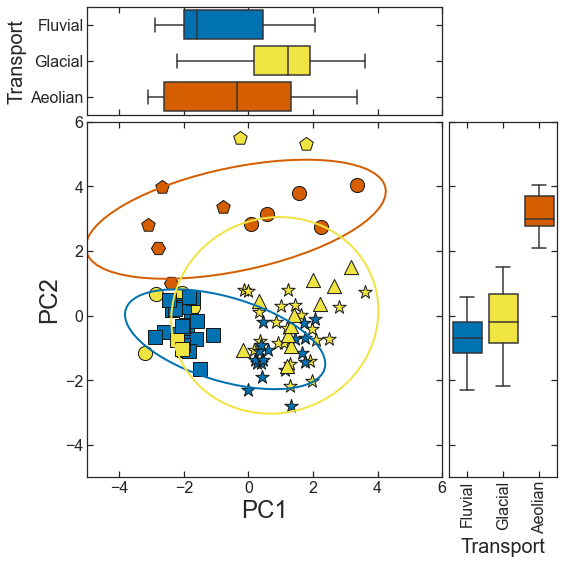

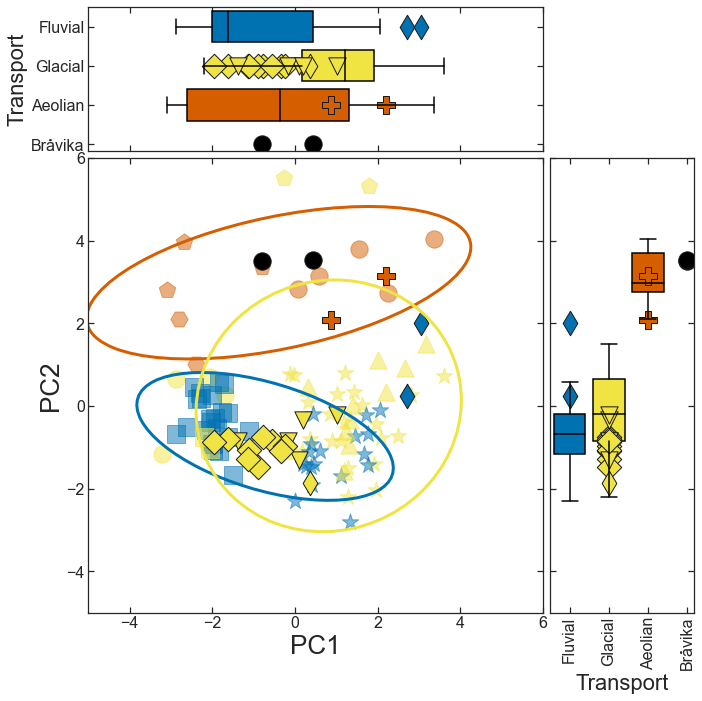

In [11]:
Composite('PC1', 'PC2', alldata, tex_allauthors, 'bleh')